<a href="https://colab.research.google.com/github/nepslor/teaching/blob/main/TimeSeriesForecasting/decision_under_uncertainty_multistage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
import json
import cvxpy as cvx
import numpy as np
import pandas as pd
from os.path import join
import matplotlib.pyplot as plt
import networkx as nx
from copy import deepcopy


In [9]:
# battery pars
pars = {'x_max':12, 
        'x_min':1,
        'p_max':4,
        'eta':0.98,
        'tau_self_discharge': 1/365/24/3600}

# add dynamic matrices
pars.update({'A': 1-pars['tau_self_discharge'],
             'B':np.array([pars['eta'], -1/pars['eta']]).reshape(1, -1)})

[print('{}: {}'.format(k, v)) for k,v in pars.items()];

x_max: 12
x_min: 1
p_max: 4
eta: 0.98
tau_self_discharge: 3.1709791983764586e-08
A: 0.999999968290208
B: [[ 0.98       -1.02040816]]


In [12]:
t = 24 # timesteps
n_scenarios = 10 # number of scenarios
p_ch = cvx.Variable((t, n_scenarios))
p_di = cvx.Variable((t, n_scenarios))

x = cvx.Variable((t, n_scenarios))
s = cvx.Variable((t, n_scenarios), boolean=True)

# parameters
x_start = cvx.Parameter((1,))
p_hat = cvx.Parameter((t, n_scenarios))
p_ref =  cvx.Parameter((t, n_scenarios))

# state constraints
c = []
c.append(x <= pars['x_max'])
c.append(x >= pars['x_min'])

# control constraints
c.append(p_ch >= 0)
c.append(p_ch <= pars['p_max'])
c.append(p_di >= 0)
c.append(p_di <= pars['p_max'])

# complementarity constraint
c.append(p_ch <= s * pars['p_max'])
c.append(p_di <= (1 - s) * pars['p_max'])

# dynamic equations
for s in range(n_scenarios):
  x_scen = cvx.hstack([x_start, x[:, s]])
  u = cvx.hstack([p_ch[:, [s]], p_di[:, [s]]])
  c.append(x_scen[1:] == x_scen[:-1] * pars['A']  + cvx.reshape(u @ pars['B'].T, t))

  # non-anticipativity constraint
  c.append(p_ch[0, s] ==  p_ch[0, np.minimum(s+1, n_scenarios-1)])
  c.append(p_di[0, s] ==  p_di[0, np.minimum(s+1, n_scenarios-1)])

obj = cvx.sum((p_ch - p_di + p_hat - p_ref)**2)
problem = cvx.Problem(cvx.Minimize(obj), constraints=c)


In [13]:
x_start.value = [5]
p_hat.value = np.outer(np.sin(np.arange(t)*3*np.pi/t).reshape(-1, 1), np.ones(n_scenarios)) + 0.1*np.cumsum(np.random.randn(t, n_scenarios), axis=0)
p_ref.value = np.zeros((t, n_scenarios))
problem.solve(solver='ECOS_BB', reltol=0.1)

19.81403380577504

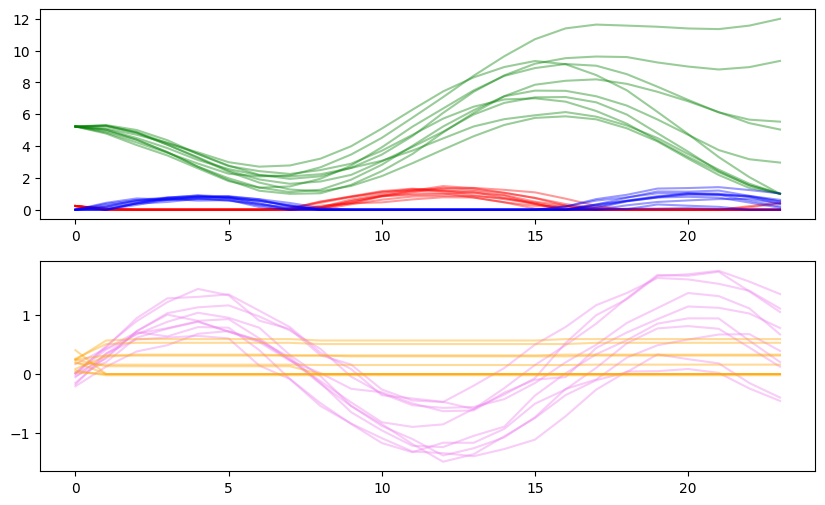

In [14]:
fig, ax = plt.subplots(2, 1, figsize=(10, 6))
ax[0].plot(x.value, color='green', alpha=0.4)
ax[0].plot(p_ch.value, color='r', alpha=0.4)
ax[0].plot(p_di.value, color='b', alpha=0.4)
ax[1].plot(p_hat.value, color='violet', alpha=0.4)
ax[1].plot(p_hat.value + p_ch.value-p_di.value, color='orange', alpha=0.4)

In [69]:
data = pd.read_csv('https://data.stadt-zuerich.ch/dataset/ewz_stromabgabe_netzebenen_stadt_zuerich/download/ewz_stromabgabe_netzebenen_stadt_zuerich.csv', index_col=0,nrows=96*365, parse_dates=[0])
print(data.head())
data.index = pd.DatetimeIndex(pd.to_datetime(data.index, utc=True))

                           Value_NE5  Value_NE7
Timestamp                                      
2010-01-01 00:15:00+01:00  18474.235  50770.765
2010-01-01 00:30:00+01:00  18168.595  49610.905
2010-01-01 00:45:00+01:00  18333.750  48503.250
2010-01-01 01:00:00+01:00  18197.865  48263.635
2010-01-01 01:15:00+01:00  18231.925  47738.575


<Axes: xlabel='Timestamp'>

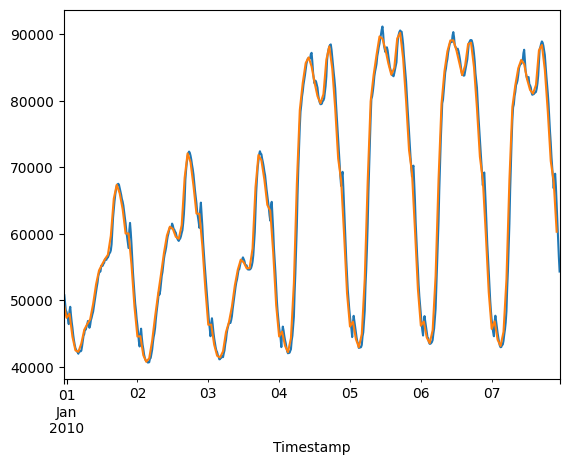

In [70]:
data['Value_NE7'].iloc[:96*7].plot()
data.index = pd.to_datetime(data.index)
data = data.resample('1h').mean()
data['Value_NE7'].iloc[:24*7].plot()

In [97]:
from lightgbm import LGBMRegressor
class LGBM:
  """
  A simple regressor-based forecaster
  """
  def __init__(self, pars):
    self.pars = pars
    self.target_cols = None
    self.models = []
    self.error_scenarios = None

  def fit(self, x, y):
    self.target_cols = y.columns
    for c in y.columns:
        m = LGBMRegressor(**self.pars).fit(x.values, y[c].values.ravel())
        self.models.append(m)
    self.error_scenarios = y.values - self.predict(x)
    return self

  def predict(self, x):
    y_hat = []
    for m, c in zip(self.models, self.target_cols):
        y_hat.append(pd.Series(m.predict(x.values), index=x.index, name=c))
    return pd.concat(y_hat, axis=1)
  
  def predict_scenarios(self, x, n_scenarios):
    y_hat = self.predict(x)
    err_scens = self.error_scenarios.values[np.random.choice(len(self.error_scenarios), n_scenarios), :].T
    return  np.expand_dims(y_hat.values, 2) + np.expand_dims(err_scens, 0)

def get_hankel(df, embedding=24*4*2):
    dfs = {}
    for col in df.columns:
        df_i = pd.concat([df[col].shift(-i) for i in range(embedding)], axis=1).iloc[:-embedding]
        df_i.columns = [i for i in range(df_i.shape[1])]
        dfs[col] = df_i
    return pd.concat(dfs, axis=1)

lagged_mav = lambda x, k: x.copy().rolling('{}d'.format(k)).mean()

target = 'Value_NE7'
n_days = 2
df_emb = get_hankel(data[[target]]-lagged_mav(data[[target]], 24*7), embedding=n_days*24)
x = df_emb.loc[:, df_emb.columns.get_level_values(1) < 24]
y = df_emb.loc[:, df_emb.columns.get_level_values(1) >= 24]
x['hour'] = x.index.hour
x['weekday'] = x.index.weekday

df = pd.concat({'x':x, 'y':y}, axis=1)
n_tr = int(len(df)*0.7)
x_tr, x_te = df['x'].iloc[:n_tr, :], df['x'].iloc[n_tr:, :]
y_tr, y_te = df['y'].iloc[:n_tr, :], df['y'].iloc[n_tr:, :]


<ipython-input-97-ffbedfd5f76f>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['hour'] = x.index.hour
<ipython-input-97-ffbedfd5f76f>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['weekday'] = x.index.weekday


In [98]:
lgb_pars = {'n_estimators': 100, 'learning_rate': 0.1, 'num_leaves': 31, 'max_depth': 5}
lgbm = LGBM(lgb_pars).fit(x_tr, y_tr)

In [114]:
from matplotlib import animation
from IPython.display import HTML
def scen_animation(y_te, y_hat, qs, n_rows=50):
    fig, ax = plt.subplots(1);
    t = np.arange(y_hat.shape[1])
    line1, = ax.plot(y_hat[0, :], lw=2);
    line2, = ax.plot(y_te[0, :], lw=2);
    line3 = ax.plot(np.squeeze(qs[0, :, :]), 'r', lw=2, alpha=0.1);
    #ax.set_ylim(-13, 13)
    def animate(i):
        line1.set_data(t, y_te[i, :]);
        line2.set_data(t, y_hat[i, :]);
        [line3[j].set_data(t, qsi) for j, qsi in enumerate(qs[i, :, :].T)];
        return (line1, line2, *line3, )

    def init():
        line1.set_data([], []);
        return (line1,)

    ani = animation.FuncAnimation(fig, animate, init_func=init, frames=n_rows, interval=100, blit=True)
    plt.close('all')
    return HTML(ani.to_jshtml())

In [116]:
plot_steps = 30
n_scens = 40
qs = lgbm.predict_scenarios(x_te.iloc[:plot_steps, :], n_scens)
scen_animation(y_te.iloc[:plot_steps, :].values, lgbm.predict(x_te.iloc[:plot_steps, :]).values, qs, n_rows=plot_steps)